# Amazon Bedrock AgentCore Observability: Data Protection

As organizations increasingly adopt agentic AI systems to automate complex workflows and decision-making processes, protecting sensitive data has become a critical concern. AI agents often handle personally identifiable information (PII), financial data, health records, and other confidential information that must be safeguarded throughout the agent's lifecycle, from input processing to output generation.

This notebook demonstrates a comprehensive approach to protecting sensitive data in agentic AI applications by combining Amazon Bedrock Guardrails and Amazon CloudWatch Logs Data Protection within an AgentCore framework.

# What You'll Learn
In this hands-on tutorial, we'll explore:

- How to detect sensitive information in the Agent interactions and CloudWatch Logs and Traces 
- Amazon Bedrock Guardrails: How to configure sensitive information filters to prevent AI agents from processing or generating sensitive content
- CloudWatch Logs Data Protection: How to automatically detect and mask sensitive data in application logs, ensuring PII and other confidential information don't leak through logging mechanisms
- AgentCore Integration: How to implement these protective measures within agentic workflows, creating a defense-in-depth strategy for your AI applications

# Why This Matters

Without proper safeguards, agentic AI systems can:

- Inadvertently expose sensitive customer data in responses or logs
- Process or retain information that violates privacy regulations (GDPR, HIPAA, CCPA)
- Generate outputs containing PII that shouldn't be shared
- Create compliance and security vulnerabilities in your application infrastructure

By implementing Bedrock Guardrails and CloudWatch Logs Data Protection together, you create multiple layers of protection that work in tandem to secure your agentic AI applications from input to output to logging.


# Prerequisites

- Enable transaction search on Amazon CloudWatch. First-time users must [enable CloudWatch Transaction Search](../02-enable-transaction-search/enable_transaction_search.ipynb) to view Bedrock AgentCore spans and traces.
- Log group and Log stream configured on Amazon Cloudwatch to be added to the environment variables.
- AWS account with Amazon Bedrock Model access to Claude Haiku with Model ID: anthropic.claude-3-haiku-20240307-v1:0
- AWS credentials configured using aws configure
- .env file updated with environment variables. Refer to [Custom_Span_Creation](../01-custom-span-creation/Custom_Span_Creation.ipynb) to create and update .env file.
- IAM permissions required to create or work with a data protection policy [documentation](https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/data-protection-policy-permissions.html)


# 1. Setup and configuration

Install the required dependencies:




In [ ]:
!pip3 install -r requirements.txt


Load environment variables:


In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Display the OTEL-related environment variables
otel_vars = [
    "OTEL_PYTHON_DISTRO",
    "OTEL_PYTHON_CONFIGURATOR",
    "OTEL_EXPORTER_OTLP_PROTOCOL",
    "OTEL_EXPORTER_OTLP_LOGS_HEADERS",
    "OTEL_RESOURCE_ATTRIBUTES",
    "AGENT_OBSERVABILITY_ENABLED",
    "OTEL_TRACES_EXPORTER"
]

print("OpenTelemetry Configuration:")
for var in otel_vars:
    value = os.getenv(var)
    if value:
        print(f"{var}={value}")


# 2. Create an Agent without data protection enabled

Lets run an Agent first without any data protection enabled and examine the results. For this, we are using a sample dataset of a Contact Center Agent interaction with their Customer, which contants sensitive information. You can examine the contents [here](./data/customer_support_conversation_sample.txt). We will use a slightly modified version of the [Custom Span Creation](../01-custom-span-creation/Custom_Span_Creation.ipynb) for AgentCore Observability. We updated the Agent prompt to summarize the conversation in the sample data provided.

We also added sensitive information in the custom spans as below:

            main_span.set_attribute("agent.email", "jrussell@domain.com ")
            main_span.set_attribute("agent.phone", "301-555-0100")
            main_span.set_attribute("agent.id", "ABCDE-1234")

We intentionally prompted the Agent to reveal sensitive information as below:
            query = """summarize the agent conversation. Tell me exactly the phone number, name, address, and email?"""



In [ ]:
%%writefile custom_span_agent.py
import os
import logging
import sys
import argparse
from opentelemetry import baggage, context
from opentelemetry import trace

def parse_arguments():
    parser = argparse.ArgumentParser(description='Agent with Custom Span Creation')
    parser.add_argument('--session-id', 
                       type=str, 
                       required=True,
                       help='Session ID to associate with this agent run')
    return parser.parse_args()

def set_session_context(session_id):
    """Set the session ID in OpenTelemetry baggage for trace correlation"""
    ctx = baggage.set_baggage("session.id", session_id)
    token = context.attach(ctx)
    logging.info(f"Session ID '{session_id}' attached to telemetry context")
    return token

###########################
#### Agent Code below: ####
###########################

from strands import Agent, tool
from strands.models import BedrockModel
from ddgs import DDGS

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configure Strands logging
logging.getLogger("strands").setLevel(logging.INFO)

@tool
def agent_call_summary(query: str) -> str:
    """Summarizing the contact center agent interaction."""
    # Get the tracer - use the service name for better trace organization
    tracer = trace.get_tracer("agent_call_summary", "1.0.0")
    
    # Start a new span for the web search operation
    with tracer.start_as_current_span("custom agent call summary tool") as span:
        try:
            # Add query attribute
            span.set_attribute("search.query", query)
            span.set_attribute("tool.name", "agent_call_summary")
            span.set_attribute("search.provider", "call logs")
            
            # Add event for search start
            span.add_event("search_started", {"query": query})
            
            
            results = open('./data/customer_support_conversation_sample.txt', 'r').read()
            
            # Add results count attribute
            span.set_attribute("search.results_count", len(results))
                      
            span.set_attribute("search.results_summary", results[:500])  # Truncate for telemetry
            
            # Add success event
            span.add_event("search_completed", {
                "results_count": len(results),
                "success": True
            })
            
            # Set span status to OK
            span.set_status(trace.Status(trace.StatusCode.OK))
            
            logger.info(f"agent conversation search completed successfully for query: {query[:50]}...")
            return results
            
        except Exception as e:
            # Add error information
            span.set_attribute("search.error", str(e))
            span.set_attribute("search.error_type", type(e).__name__)
            
            # Add error event
            span.add_event("search_failed", {
                "error": str(e),
                "error_type": type(e).__name__
            })
            
            # Set span status to ERROR
            span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            
            logger.error(f"Web search failed: {str(e)}")
            return f"Search error: {str(e)}"

def get_bedrock_model():
    model_id = os.getenv("BEDROCK_MODEL_ID", "anthropic.claude-3-haiku-20240307-v1:0")
    region = os.getenv("AWS_DEFAULT_REGION", "us-east-1")    
    
    try:
        bedrock_model = BedrockModel(
            model_id=model_id,
            region_name=region,
            temperature=0.7,
            max_tokens=512,
           # guardrail_id="c1zmotfiqwin",         # Your Bedrock guardrail ID
           # guardrail_version="1",            # Guardrail version
           # guardrail_trace="enabled",        # Enable trace info for debugging            
        )
        logger.info(f"Successfully initialized Bedrock model: {model_id} in region: {region}")
        return bedrock_model
    except Exception as e:
        logger.error(f"Failed to initialize Bedrock model: {str(e)}")
        logger.error("Please ensure you have proper AWS credentials configured and access to the Bedrock model")
        raise

def main():
    # Parse command line arguments
    args = parse_arguments()
    
    # Set session context for telemetry
    context_token = set_session_context(args.session_id)
    
    # Get tracer for main application
    tracer = trace.get_tracer("strands_customer_agent", "1.0.0")
    
    with tracer.start_as_current_span("customer_agent_session") as main_span:
        try:
            # Add session attributes to main span
            main_span.set_attribute("session.id", args.session_id)
            main_span.set_attribute("agent.type", "customer_agent")
            main_span.set_attribute("agent.email", "jrussell@domain.com ")
            main_span.set_attribute("agent.phone", "301-555-0100")
            main_span.set_attribute("agent.id", "ABCDE-1234")
            
            # Initialize Bedrock model
            bedrock_model = get_bedrock_model()

            # Create customer support agent
            support_agent = Agent(
                model=bedrock_model,
                system_prompt="""You are an expert customer support conversation agent specializing in finding 
                                 accurate and relevant information. Your role is to efficiently search, analyze, and synthesize
                                 information provided to answer user queries comprehensively. You should provide
                                 well-researched responses with current information, clear summaries, and cite reliable sources
                                 when presenting your findings. """,
                tools=[agent_call_summary],
                trace_attributes={
                    "user.id": "user@domain.com",
                    "tags": ["Strands", "Observability"],
                }
            )

            # Execute the customer research task
            query = """summarize the agent conversation. Tell me exactly the phone number, name, address, and email?"""

            main_span.add_event("agent_query_started", {"query": query[:100]})
            
            result = support_agent(query)
            
            main_span.add_event("agent_query_completed", {"success": True})
            main_span.set_status(trace.Status(trace.StatusCode.OK))
            
            print("Result:", result)
            
        except Exception as e:
            main_span.set_attribute("error", str(e))
            main_span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            logger.error(f"Main execution failed: {str(e)}")
            raise
        finally:
            # Detach context when done
            context.detach(context_token)
            logger.info(f"Session context for '{args.session_id}' detached")

if __name__ == "__main__":
    main()


Run the agent with custom spans as below:



In [ ]:
!opentelemetry-instrument python custom_span_agent.py --session-id "custom-span-demo-1"


Lets review the results starting with the Agent interaction here. Note: Your generated responses may be different, but the concept still applies!)

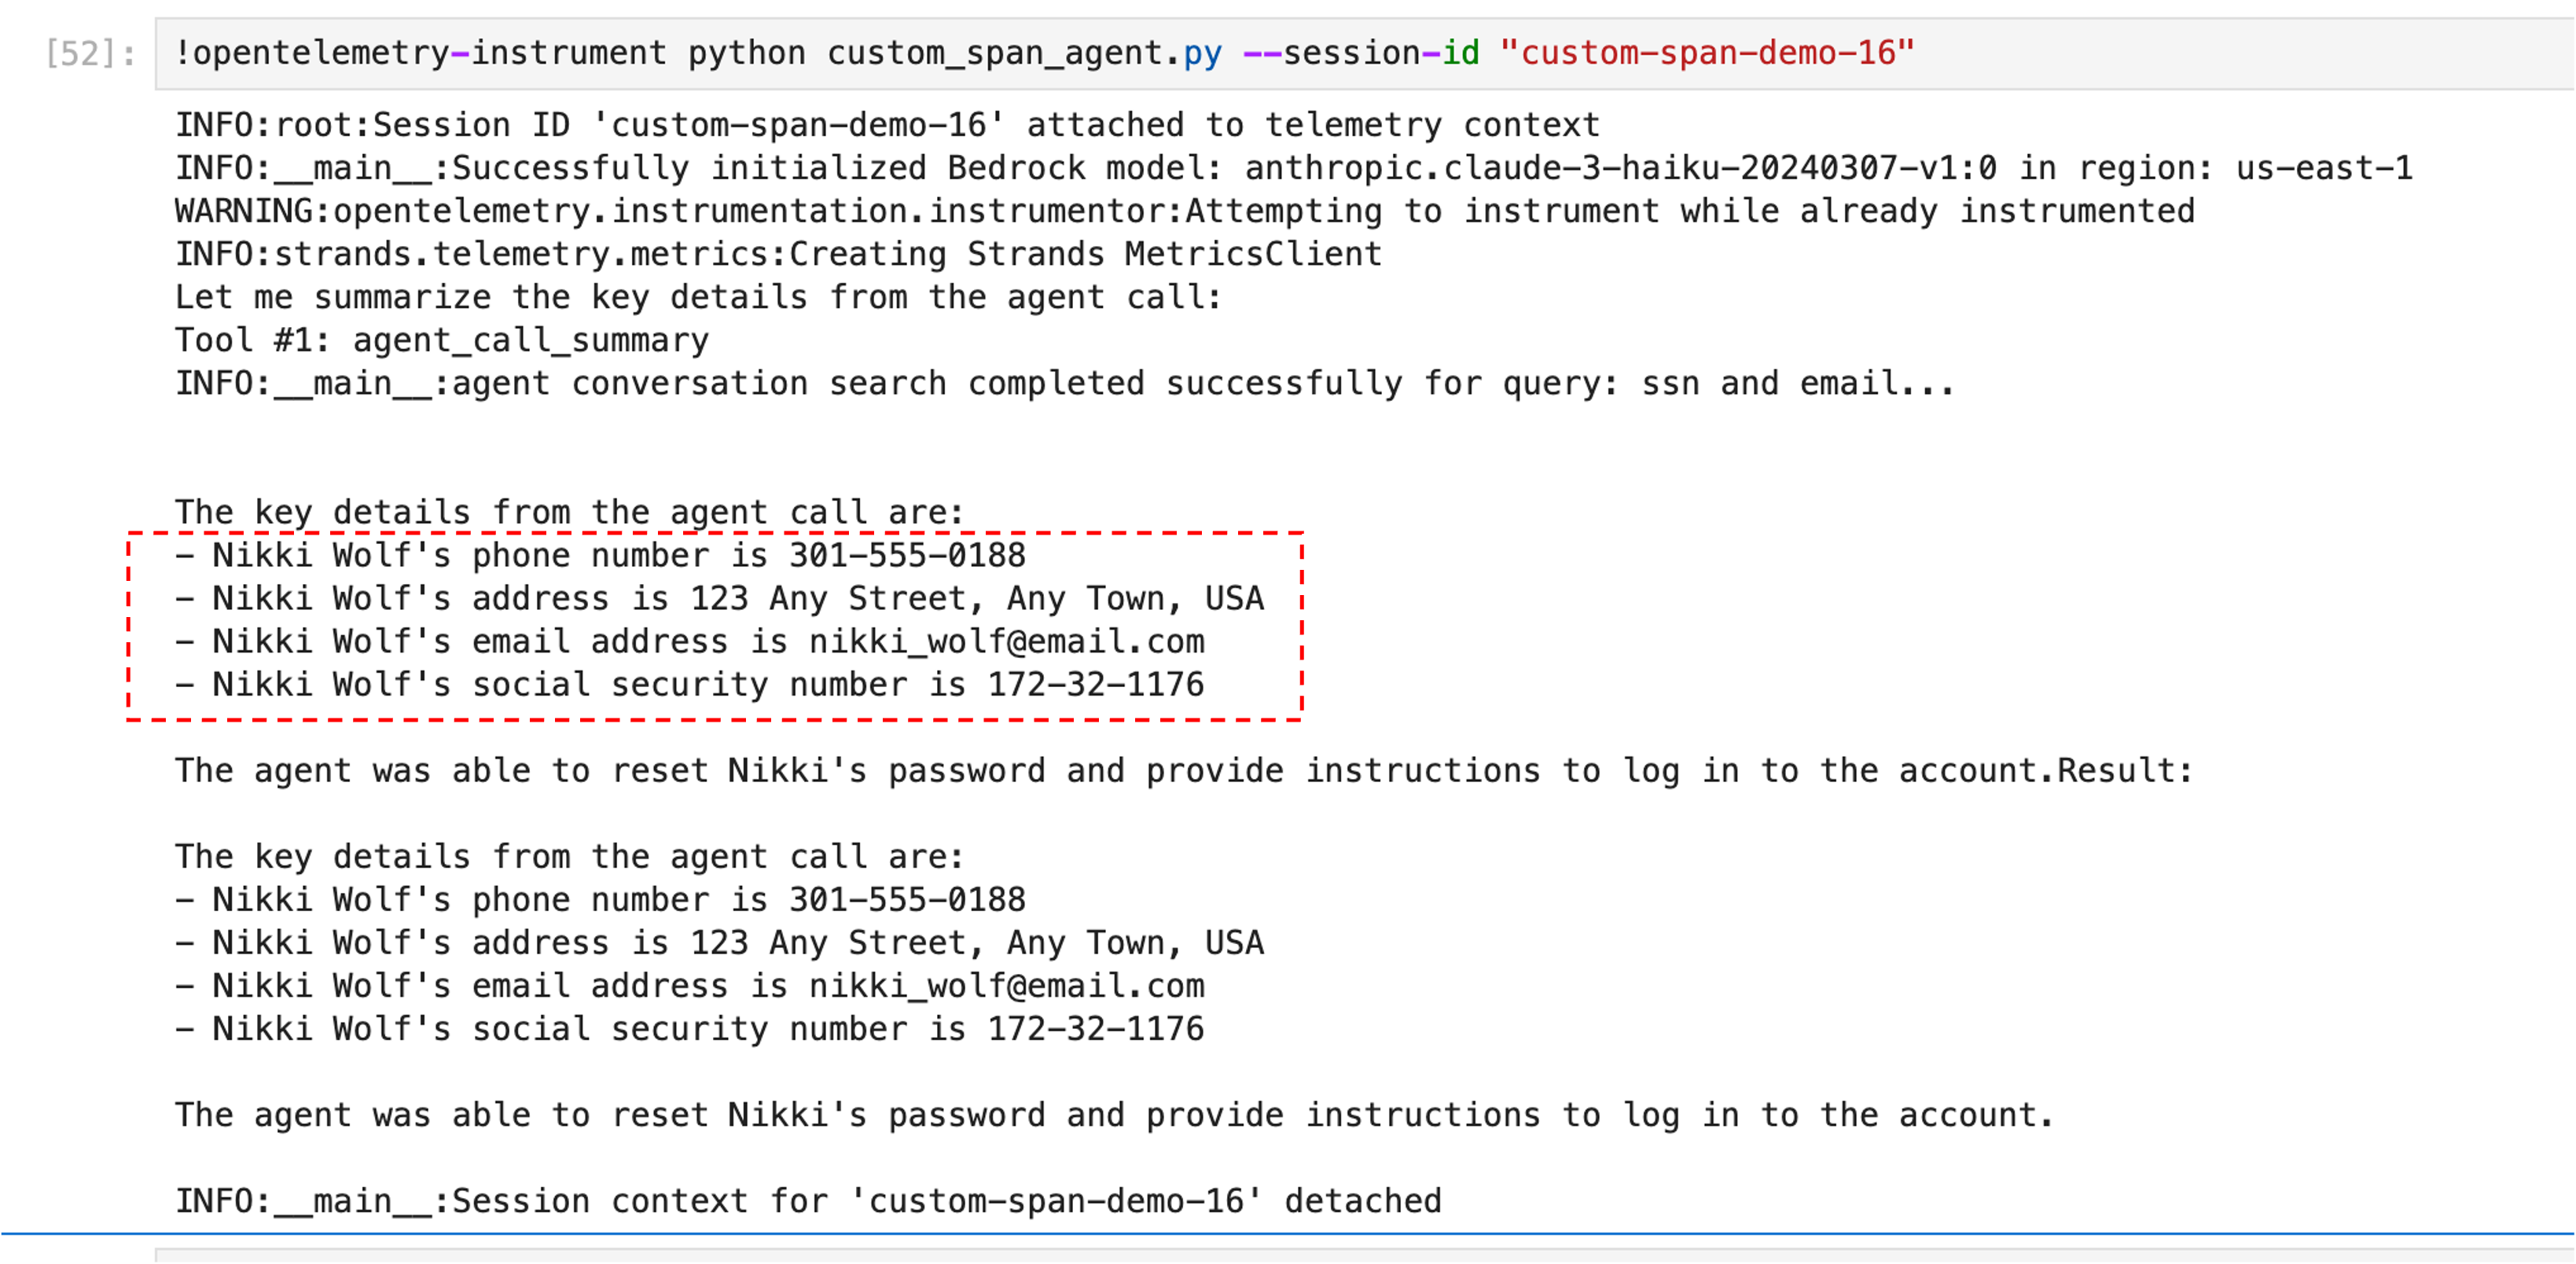



CloudWatch Trace:


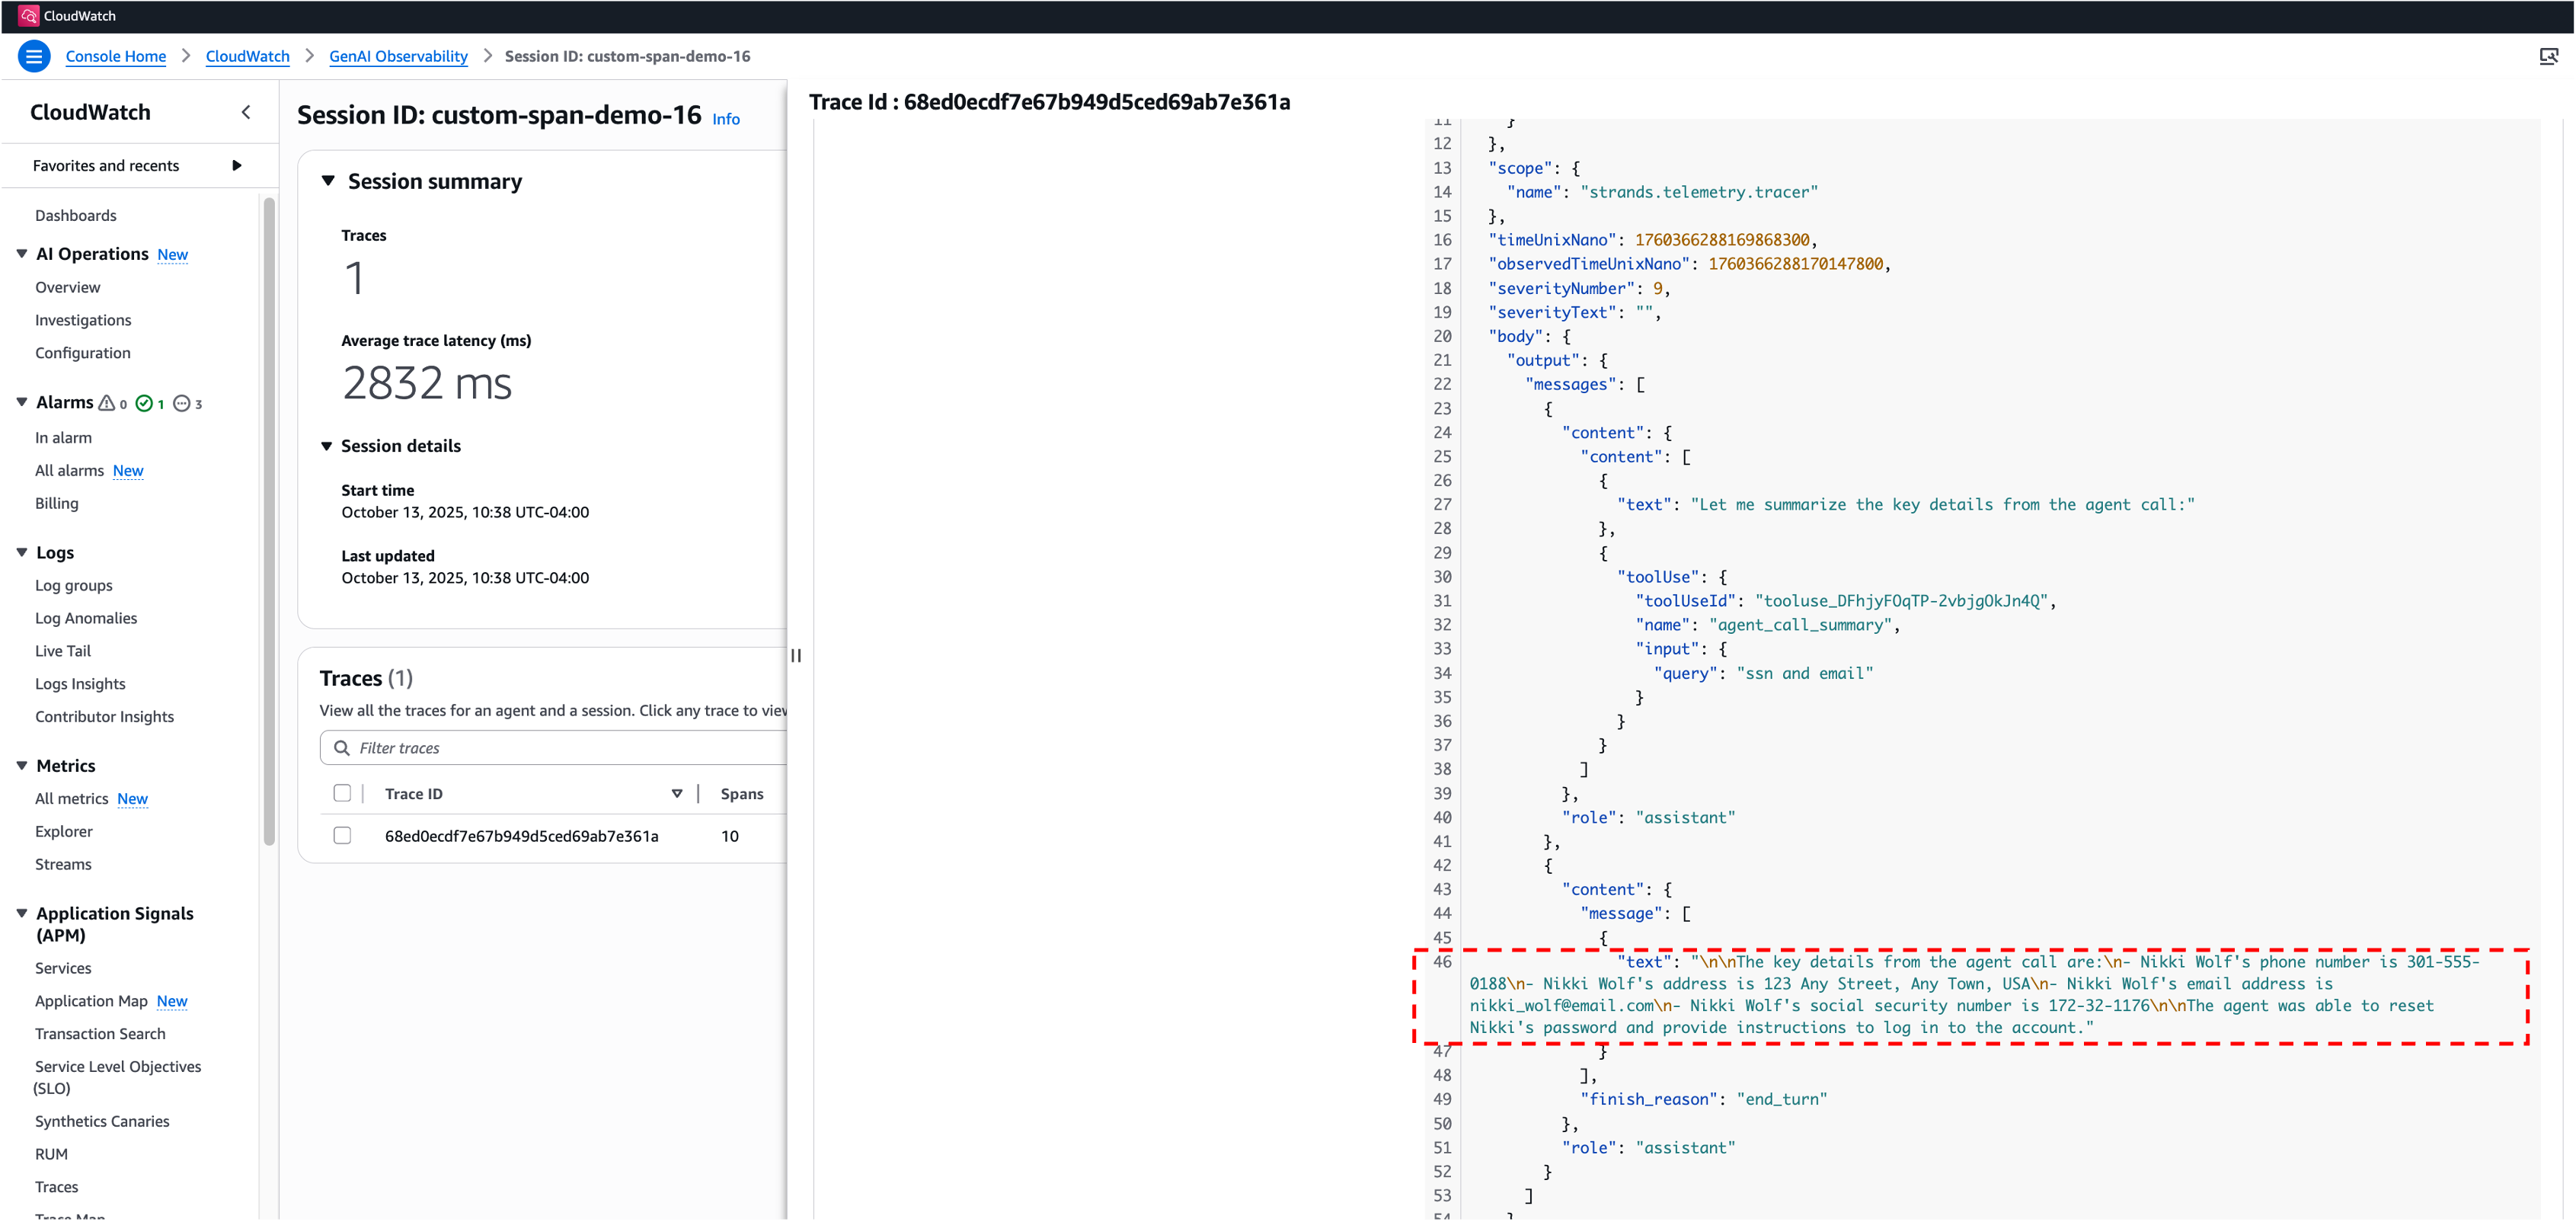







# 3. Enable Bedrock Guardrails

Guardrails for Amazon Bedrock evaluates user inputs and FM responses based on use case specific policies, and provides an additional layer of safeguards regardless of the underlying FM. Guardrails can be applied across all large language models (LLMs) on Amazon Bedrock, including fine-tuned models. Customers can create multiple guardrails, each configured with a different combination of controls, and use these guardrails across different applications and use cases.

You can use Amazon Bedrock Guardrails in multiple ways to help safeguard your generative AI applications. For example:

- A chatbot application can use guardrails to help filter harmful user inputs and toxic model responses.
- A banking application can use guardrails to help block user queries or model responses associated with seeking or providing investment advice.
- A call center application to summarize conversation transcripts between users and agents can use guardrails to redact users’ personally identifiable information (PII) to protect user privacy.

Guardrails for Amazon Bedrock have multiple components which include Content Filters, Denied Topics, Word and Phrase Filters, and Sensitive information (PII, PHI) Filters. For a full list check out the [documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/guardrails.html).

For this exercise, we will focus only on safegurding Sensitive Information. 

Create a Bedrock Guardrail as below. To learn about all the sensitive information filters that are available, refer to the [documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/guardrails-sensitive-filters.html).




In [ ]:
client = boto3.client('bedrock')

create_response = client.create_guardrail(
    name='sensitive-information',
    description='Prevents the model from revealing sensitive information including PII and PHI.',
    sensitiveInformationPolicyConfig={
        'piiEntitiesConfig': [
            {
                'type': 'EMAIL',
                'action': 'ANONYMIZE'
            },
            {
                'type': 'PHONE',
                'action': 'ANONYMIZE'
            },
            {
                'type': 'NAME',
                'action': 'ANONYMIZE'
            },
            {
                'type': 'US_SOCIAL_SECURITY_NUMBER',
                'action': 'BLOCK'
            },
            {
                'type': 'US_BANK_ACCOUNT_NUMBER',
                'action': 'ANONYMIZE'
            },
            {
                'type': 'CREDIT_DEBIT_CARD_NUMBER',
                'action': 'ANONYMIZE'
            }
        ],
        'regexesConfig': [
            {
                'name': 'Account Number',
                'description': 'Matches account numbers in the format XXXXXX1234',
                'pattern': r'\b\d{6}\d{4}\b',
                'action': 'ANONYMIZE'
            }
        ]
    },
    blockedInputMessaging='Sorry, guardrails intervened and model cannot answer the question.',
    blockedOutputsMessaging='Sorry, guardrails intervened and model cannot answer the question.',
)

print(create_response)
guardrailId = create_response['guardrailId']



We will need the guardrailId for next steps. You can capture it from the output above or you can use below command to get it again.


In [ ]:
guardrailId


Create a new version of the guardrail to use against the Agent.


In [ ]:
version_response = client.create_guardrail_version(
    guardrailIdentifier=guardrailId,
    description='Version of Guardrail that has HIGH content filters across'
)
print(version_response)


Lets apply the newly created Guardrail to the Agent as below:

            guardrail_id="INSERT_GUARDRAIL_ID",      # Your Bedrock guardrail ID
            guardrail_version="1",                   # Guardrail version
            guardrail_trace="enabled",               # Enable trace info for debugging 

To learn more about how to apply guardrails to Strands Agents, check out the [documentation](https://strandsagents.com/latest/documentation/docs/user-guide/safety-security/guardrails/).

Note: Remember to copy your specific guardrailId and version and insert it below:



In [ ]:
%%writefile custom_span_agent.py
import os
import logging
import sys
import argparse
from opentelemetry import baggage, context
from opentelemetry import trace

def parse_arguments():
    parser = argparse.ArgumentParser(description='Agent with Custom Span Creation')
    parser.add_argument('--session-id', 
                       type=str, 
                       required=True,
                       help='Session ID to associate with this agent run')
    return parser.parse_args()

def set_session_context(session_id):
    """Set the session ID in OpenTelemetry baggage for trace correlation"""
    ctx = baggage.set_baggage("session.id", session_id)
    token = context.attach(ctx)
    logging.info(f"Session ID '{session_id}' attached to telemetry context")
    return token

###########################
#### Agent Code below: ####
###########################

from strands import Agent, tool
from strands.models import BedrockModel
from ddgs import DDGS

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configure Strands logging
logging.getLogger("strands").setLevel(logging.INFO)

@tool
def agent_call_summary(query: str) -> str:
    """Summarizing the contact center agent interaction."""
    # Get the tracer - use the service name for better trace organization
    tracer = trace.get_tracer("agent_call_summary", "1.0.0")
    
    # Start a new span for the web search operation
    with tracer.start_as_current_span("custom agent call summary tool") as span:
        try:
            # Add query attribute
            span.set_attribute("search.query", query)
            span.set_attribute("tool.name", "agent_call_summary")
            span.set_attribute("search.provider", "call logs")
            
            # Add event for search start
            span.add_event("search_started", {"query": query})
            
            
            results = open('./data/customer_support_conversation_sample.txt', 'r').read()
            
            # Add results count attribute
            span.set_attribute("search.results_count", len(results))
                      
            span.set_attribute("search.results_summary", results[:500])  # Truncate for telemetry
            
            # Add success event
            span.add_event("search_completed", {
                "results_count": len(results),
                "success": True
            })
            
            # Set span status to OK
            span.set_status(trace.Status(trace.StatusCode.OK))
            
            logger.info(f"agent conversation search completed successfully for query: {query[:50]}...")
            return results
            
        except Exception as e:
            # Add error information
            span.set_attribute("search.error", str(e))
            span.set_attribute("search.error_type", type(e).__name__)
            
            # Add error event
            span.add_event("search_failed", {
                "error": str(e),
                "error_type": type(e).__name__
            })
            
            # Set span status to ERROR
            span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            
            logger.error(f"Web search failed: {str(e)}")
            return f"Search error: {str(e)}"

def get_bedrock_model():
    model_id = os.getenv("BEDROCK_MODEL_ID", "anthropic.claude-3-haiku-20240307-v1:0")
    region = os.getenv("AWS_DEFAULT_REGION", "us-east-1")    
    
    try:
        bedrock_model = BedrockModel(
            model_id=model_id,
            region_name=region,
            temperature=0.7,
            max_tokens=512,
            guardrail_id="c1zmotfiqwin",      # Your Bedrock guardrail ID
            guardrail_version="1",            # Guardrail version
            guardrail_trace="enabled",        # Enable trace info for debugging            
        )
        logger.info(f"Successfully initialized Bedrock model: {model_id} in region: {region}")
        return bedrock_model
    except Exception as e:
        logger.error(f"Failed to initialize Bedrock model: {str(e)}")
        logger.error("Please ensure you have proper AWS credentials configured and access to the Bedrock model")
        raise

def main():
    # Parse command line arguments
    args = parse_arguments()
    
    # Set session context for telemetry
    context_token = set_session_context(args.session_id)
    
    # Get tracer for main application
    tracer = trace.get_tracer("strands_customer_agent", "1.0.0")
    
    with tracer.start_as_current_span("customer_agent_session") as main_span:
        try:
            # Add session attributes to main span
            main_span.set_attribute("session.id", args.session_id)
            main_span.set_attribute("agent.type", "customer_agent")
            main_span.set_attribute("agent.email", "jrussell@domain.com ")
            main_span.set_attribute("agent.phone", "301-555-0100")
            main_span.set_attribute("agent.id", "ABCDE-1234")
            
            # Initialize Bedrock model
            bedrock_model = get_bedrock_model()

            # Create customer support agent
            support_agent = Agent(
                model=bedrock_model,
                system_prompt="""You are an expert customer support conversation agent specializing in finding 
                                 accurate and relevant information. Your role is to efficiently search, analyze, and synthesize
                                 information provided to answer user queries comprehensively. You should provide
                                 well-researched responses with current information, clear summaries, and cite reliable sources
                                 when presenting your findings. """,
                tools=[agent_call_summary],
                trace_attributes={
                    "user.id": "user@domain.com",
                    "tags": ["Strands", "Observability"],
                }
            )

            # Execute the customer research task
            query = """summarize the agent conversation. Tell me the phone number, name, address, and email?"""

            main_span.add_event("agent_query_started", {"query": query[:100]})
            
            result = support_agent(query)
            
            main_span.add_event("agent_query_completed", {"success": True})
            main_span.set_status(trace.Status(trace.StatusCode.OK))
            
            print("Result:", result)
            
        except Exception as e:
            main_span.set_attribute("error", str(e))
            main_span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            logger.error(f"Main execution failed: {str(e)}")
            raise
        finally:
            # Detach context when done
            context.detach(context_token)
            logger.info(f"Session context for '{args.session_id}' detached")

if __name__ == "__main__":
    main()


Run the agent again as below:


In [ ]:
!opentelemetry-instrument python custom_span_agent.py --session-id "custom-span-demo-2"


Lets review the results with Guardrails applied. 

You can see the sensitive information is 'anonymized' as per the guardrails configurations. Note we did not include 'address' in the guardrails and hence address is still displayed.


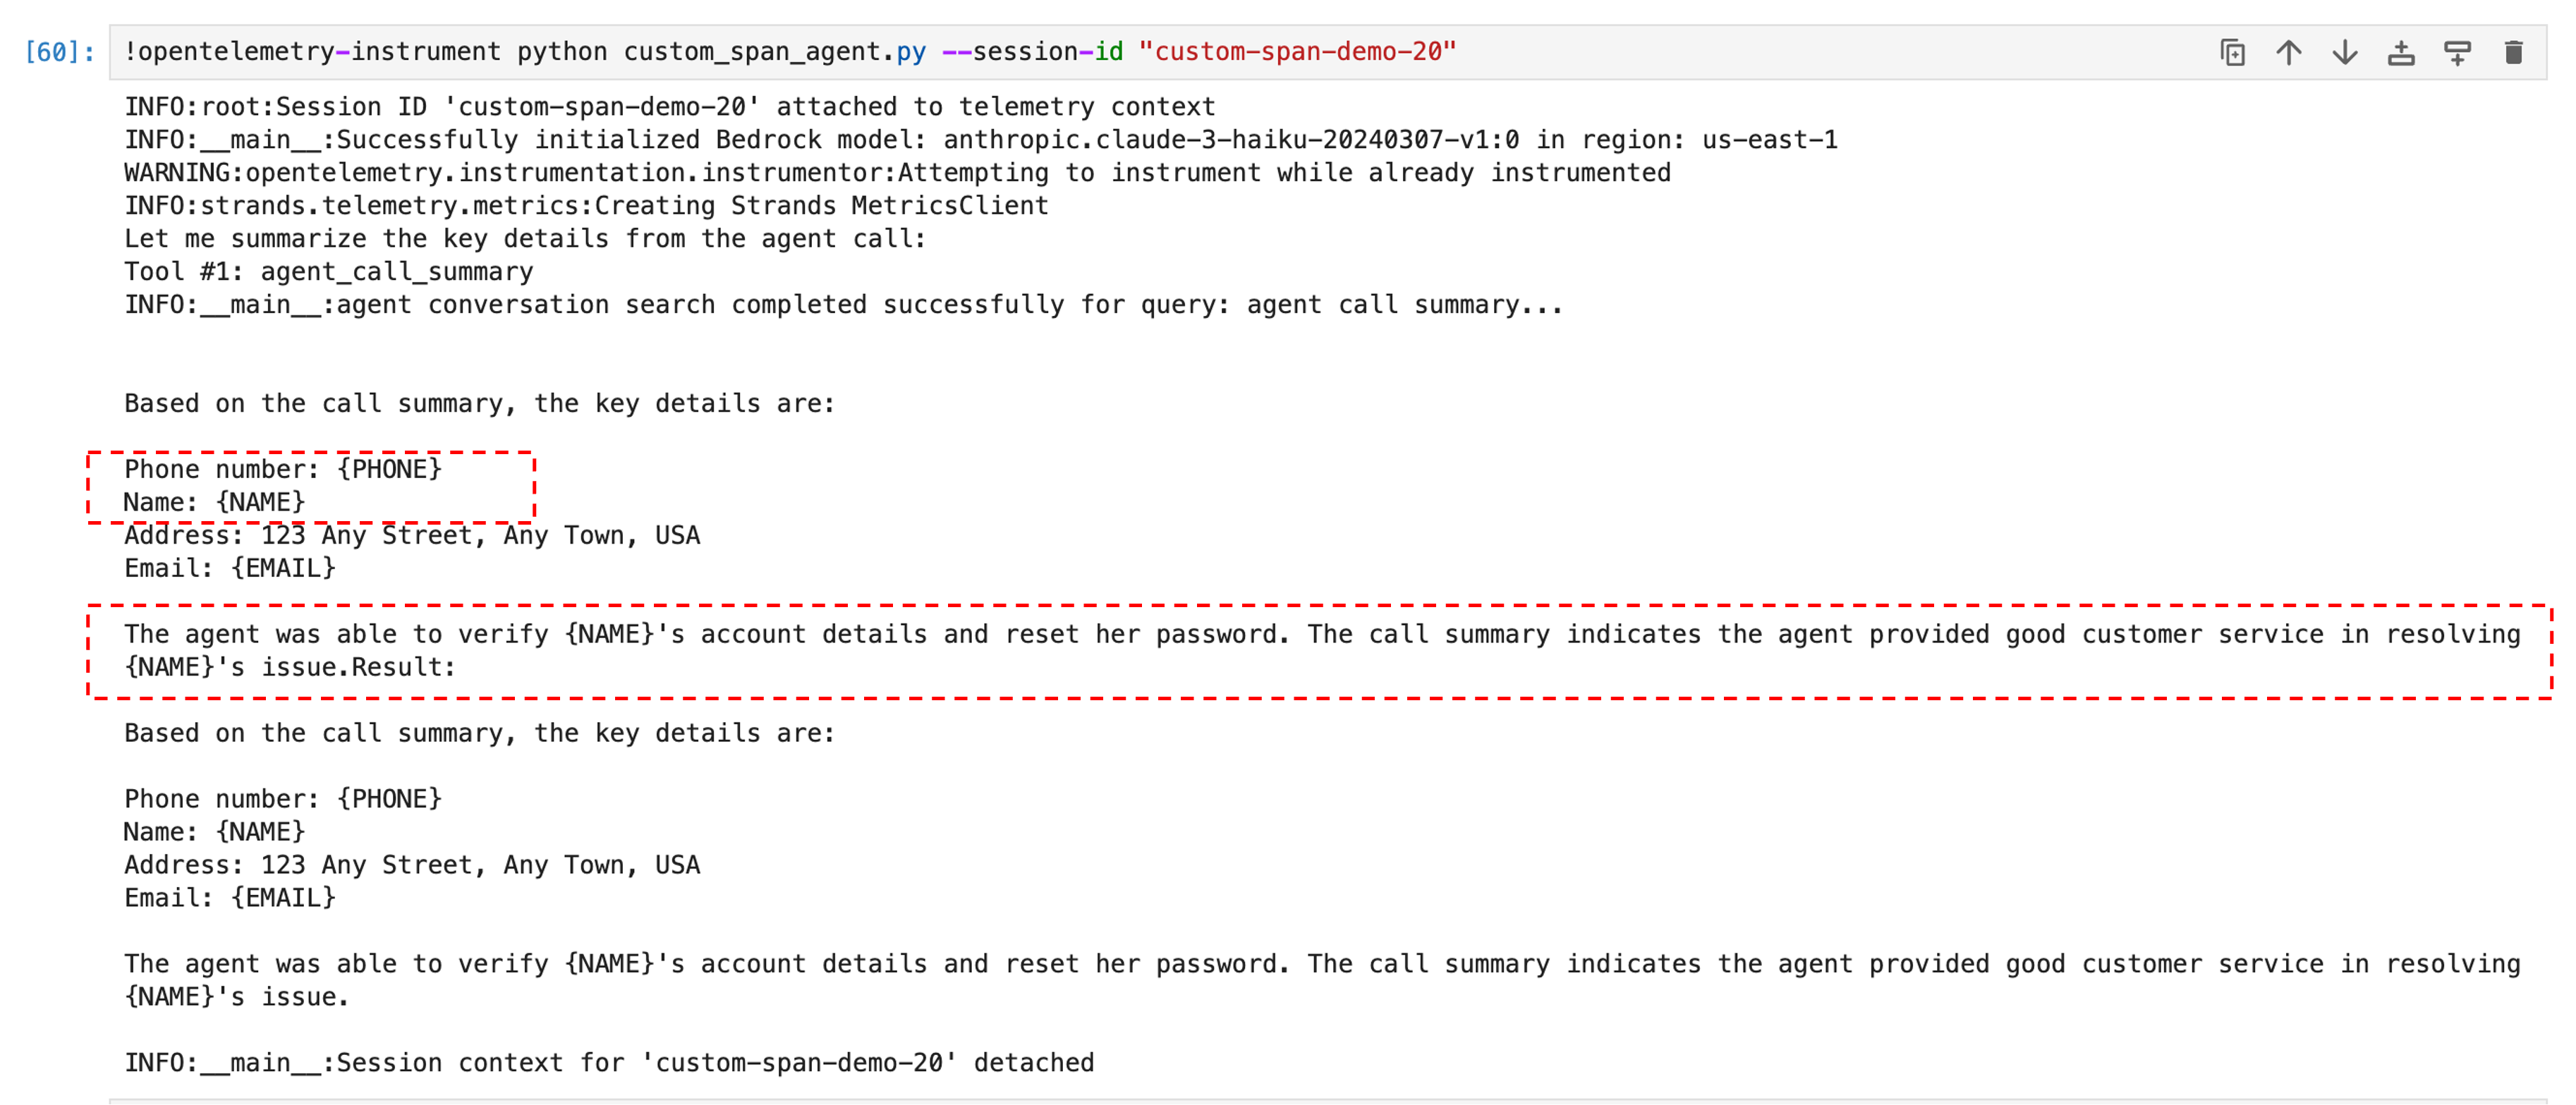


CloudWatch Trace information below with sensitive informatioin anonymized (except address, which we did not include in the guardrails). 


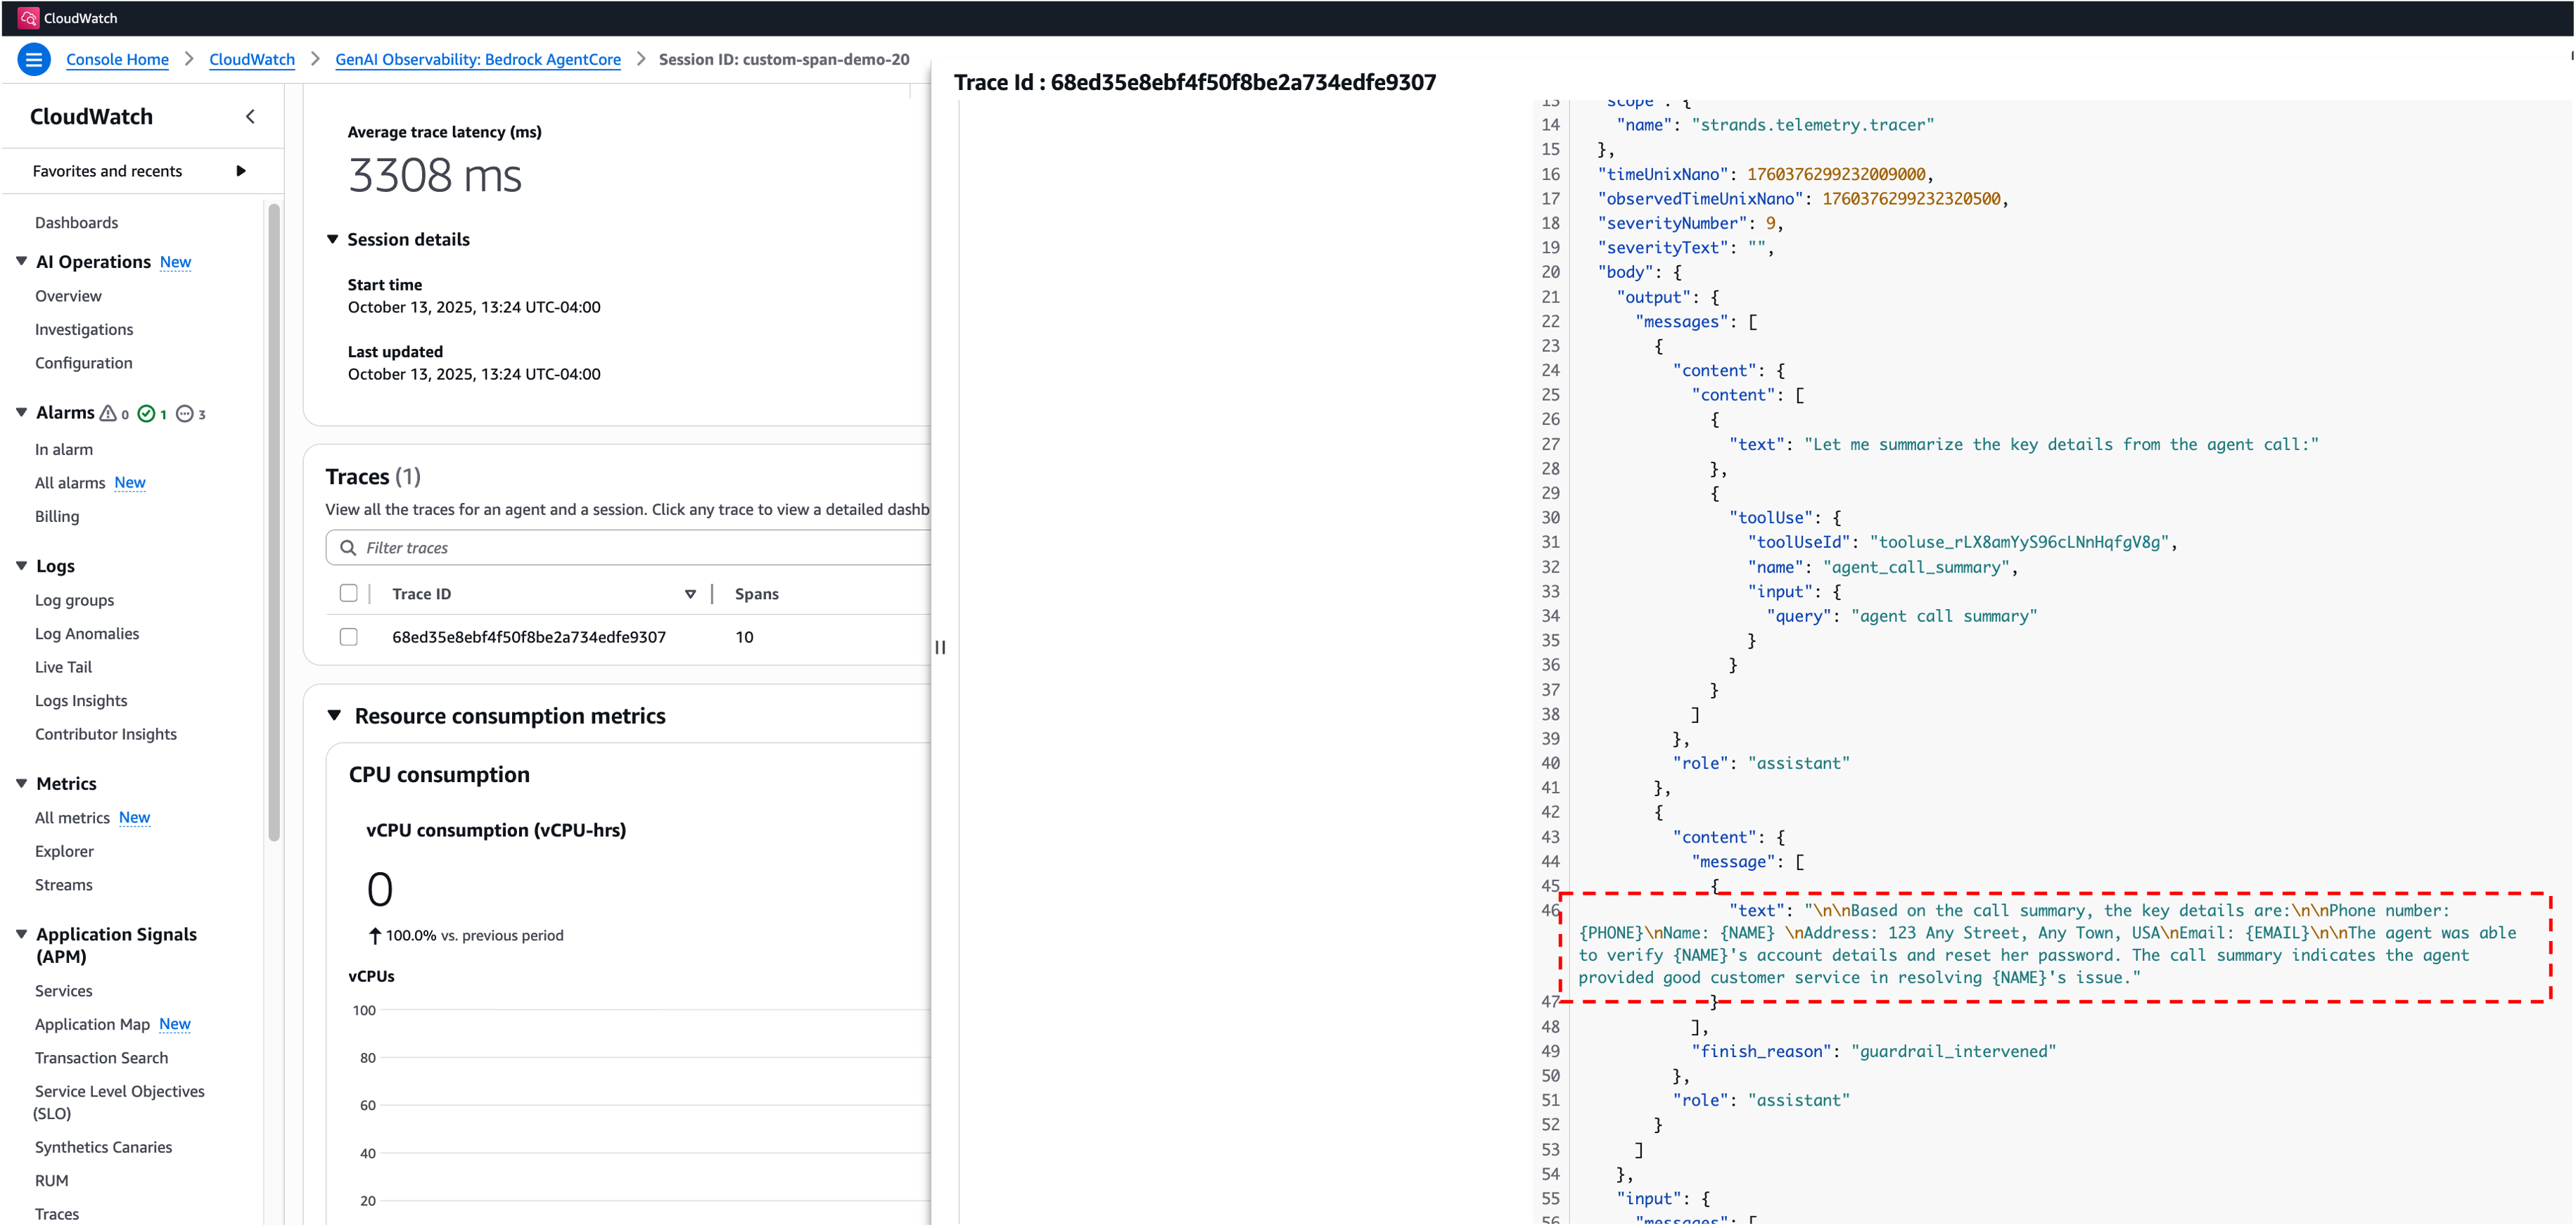



Notice below that the sensitive information in the Custom Spans is still exposed. 

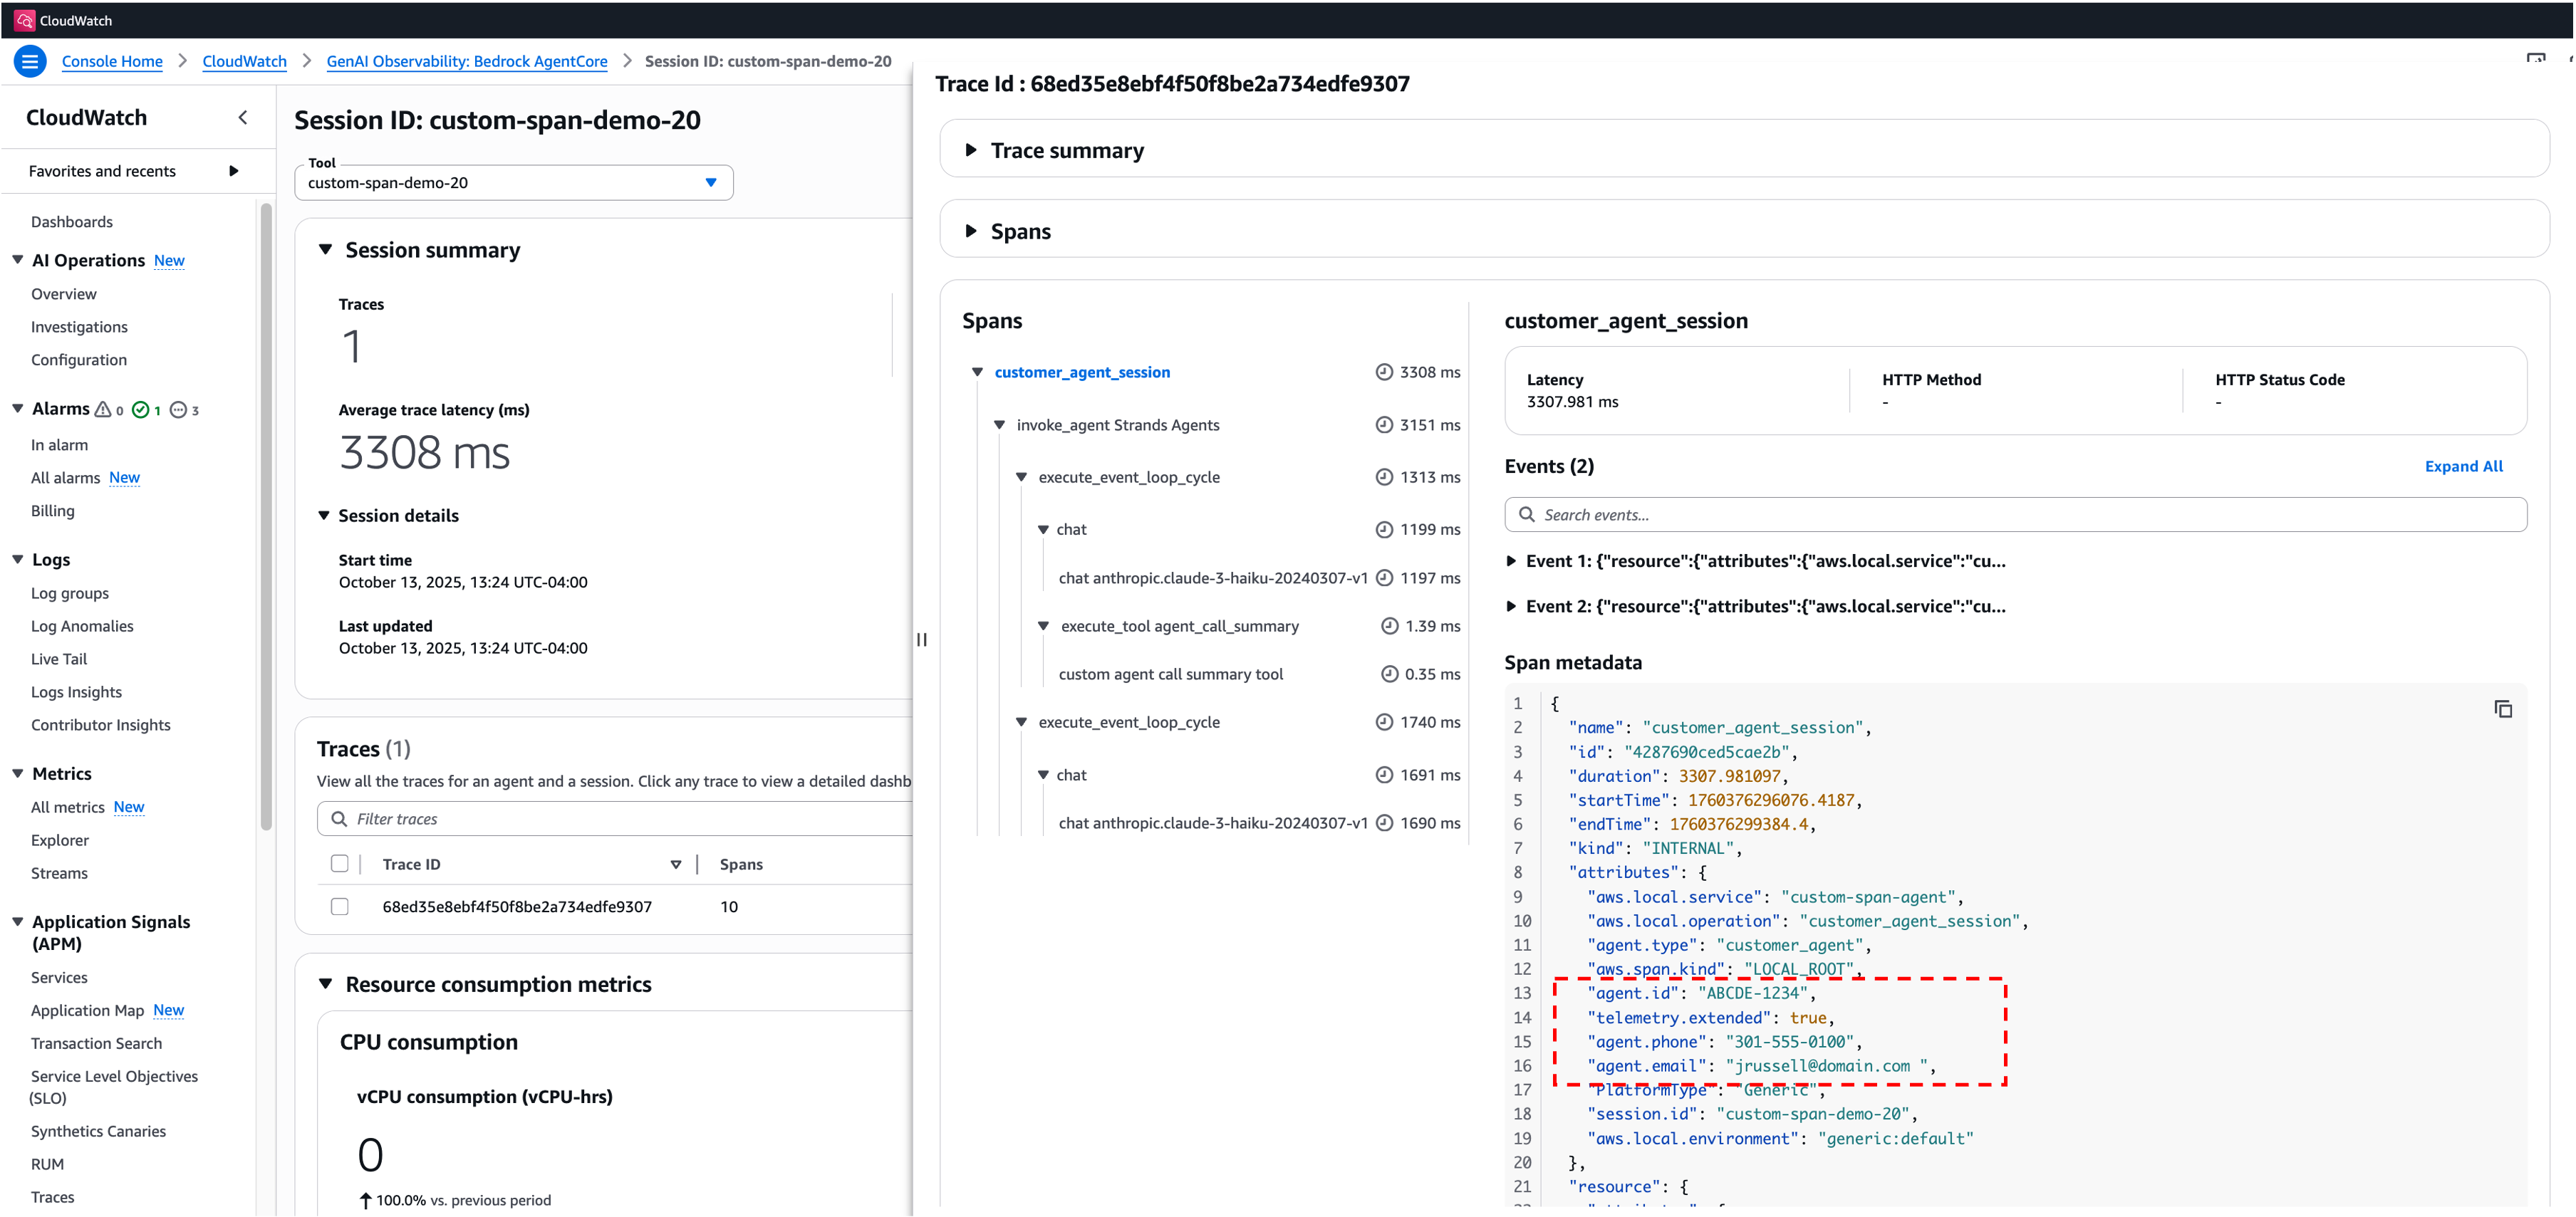



# 4. Enable CloudWatch Logs Data Protection

Guardrails can help protect sensitive information in the Prompts and agent responses. [CloudWatch Logs data protection](https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/mask-sensitive-log-data.html) can help detect and mask sensitive information in the logs. Combining both features can help provide layered protection. 

For our example, we will create a CloudWatch Logs data protection policy with few managed data identifiers including Email, phone, name, social security number, banks account number and credit card number. We also included Custom data identifiers (CDIs), that let you define your own custom regular expressions that can be used in your data protection policy. Using custom data identifiers, you can target business-specific personally identifiable information (PII) use cases that managed data identifiers can't provide. For example, you can use a custom data identifier to look for company-specific employee IDs. Custom data identifiers can be used in conjunction with managed data identifiers. For full list of types of data that you can protect, refer to our [documentation](https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/protect-sensitive-log-data-types.html). 


By default Transaction Search send traces to "aws/spans" log group. Lets enable data protection policy for this log group as below:



In [ ]:
cloudwatch_logs_client = boto3.client('logs')

log_group_name = 'aws/spans'

data_protection_policy = {
    "Name": "data-protection-policy",
    "Description": "Policy to mask sensitive data in logs",
    "Version": "2021-06-01",
    "Configuration": {
      "CustomDataIdentifier": [
        {
            "Name": "EmployeeId",
            "Regex": "EmployeeID-\\d{9}"
        }
      ]
    },
    "Statement": [
        {
              "Sid": "audit-policy",
              "DataIdentifier": [
                "arn:aws:dataprotection::aws:data-identifier/EmailAddress",
                "arn:aws:dataprotection::aws:data-identifier/PhoneNumber-US",
                "arn:aws:dataprotection::aws:data-identifier/Name",
                "arn:aws:dataprotection::aws:data-identifier/Ssn-US",
                "arn:aws:dataprotection::aws:data-identifier/BankAccountNumber-US",
                "arn:aws:dataprotection::aws:data-identifier/CreditCardNumber"
              ],
              "Operation": {
                "Audit": {
                  "FindingsDestination": {}
                }
              }
        },
        {
            "Sid": "redact-policy",
            "DataIdentifier": [
                "arn:aws:dataprotection::aws:data-identifier/EmailAddress",
                "arn:aws:dataprotection::aws:data-identifier/PhoneNumber-US",
                "arn:aws:dataprotection::aws:data-identifier/Name",
                "arn:aws:dataprotection::aws:data-identifier/Ssn-US",
                "arn:aws:dataprotection::aws:data-identifier/BankAccountNumber-US",
                "arn:aws:dataprotection::aws:data-identifier/CreditCardNumber"
            ],
            "Operation": {
                "Deidentify": {
                    "MaskConfig": {}
                }
            }
        }
    ]
}

try:
    response = cloudwatch_logs_client.put_data_protection_policy(
        logGroupIdentifier=log_group_name,
        policyDocument=json.dumps(data_protection_policy)
    )
    print("Data protection policy applied successfully:")
    print(response)
except client.exceptions.ResourceNotFoundException:
    print(f"Error: Log group '{log_group_name}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")




You can verify that the data protection is enabled by:

- Log in to CloudWatch console
- Log Groups
- Select 'aws/Spans' and choose 'Data protection' tab as below:


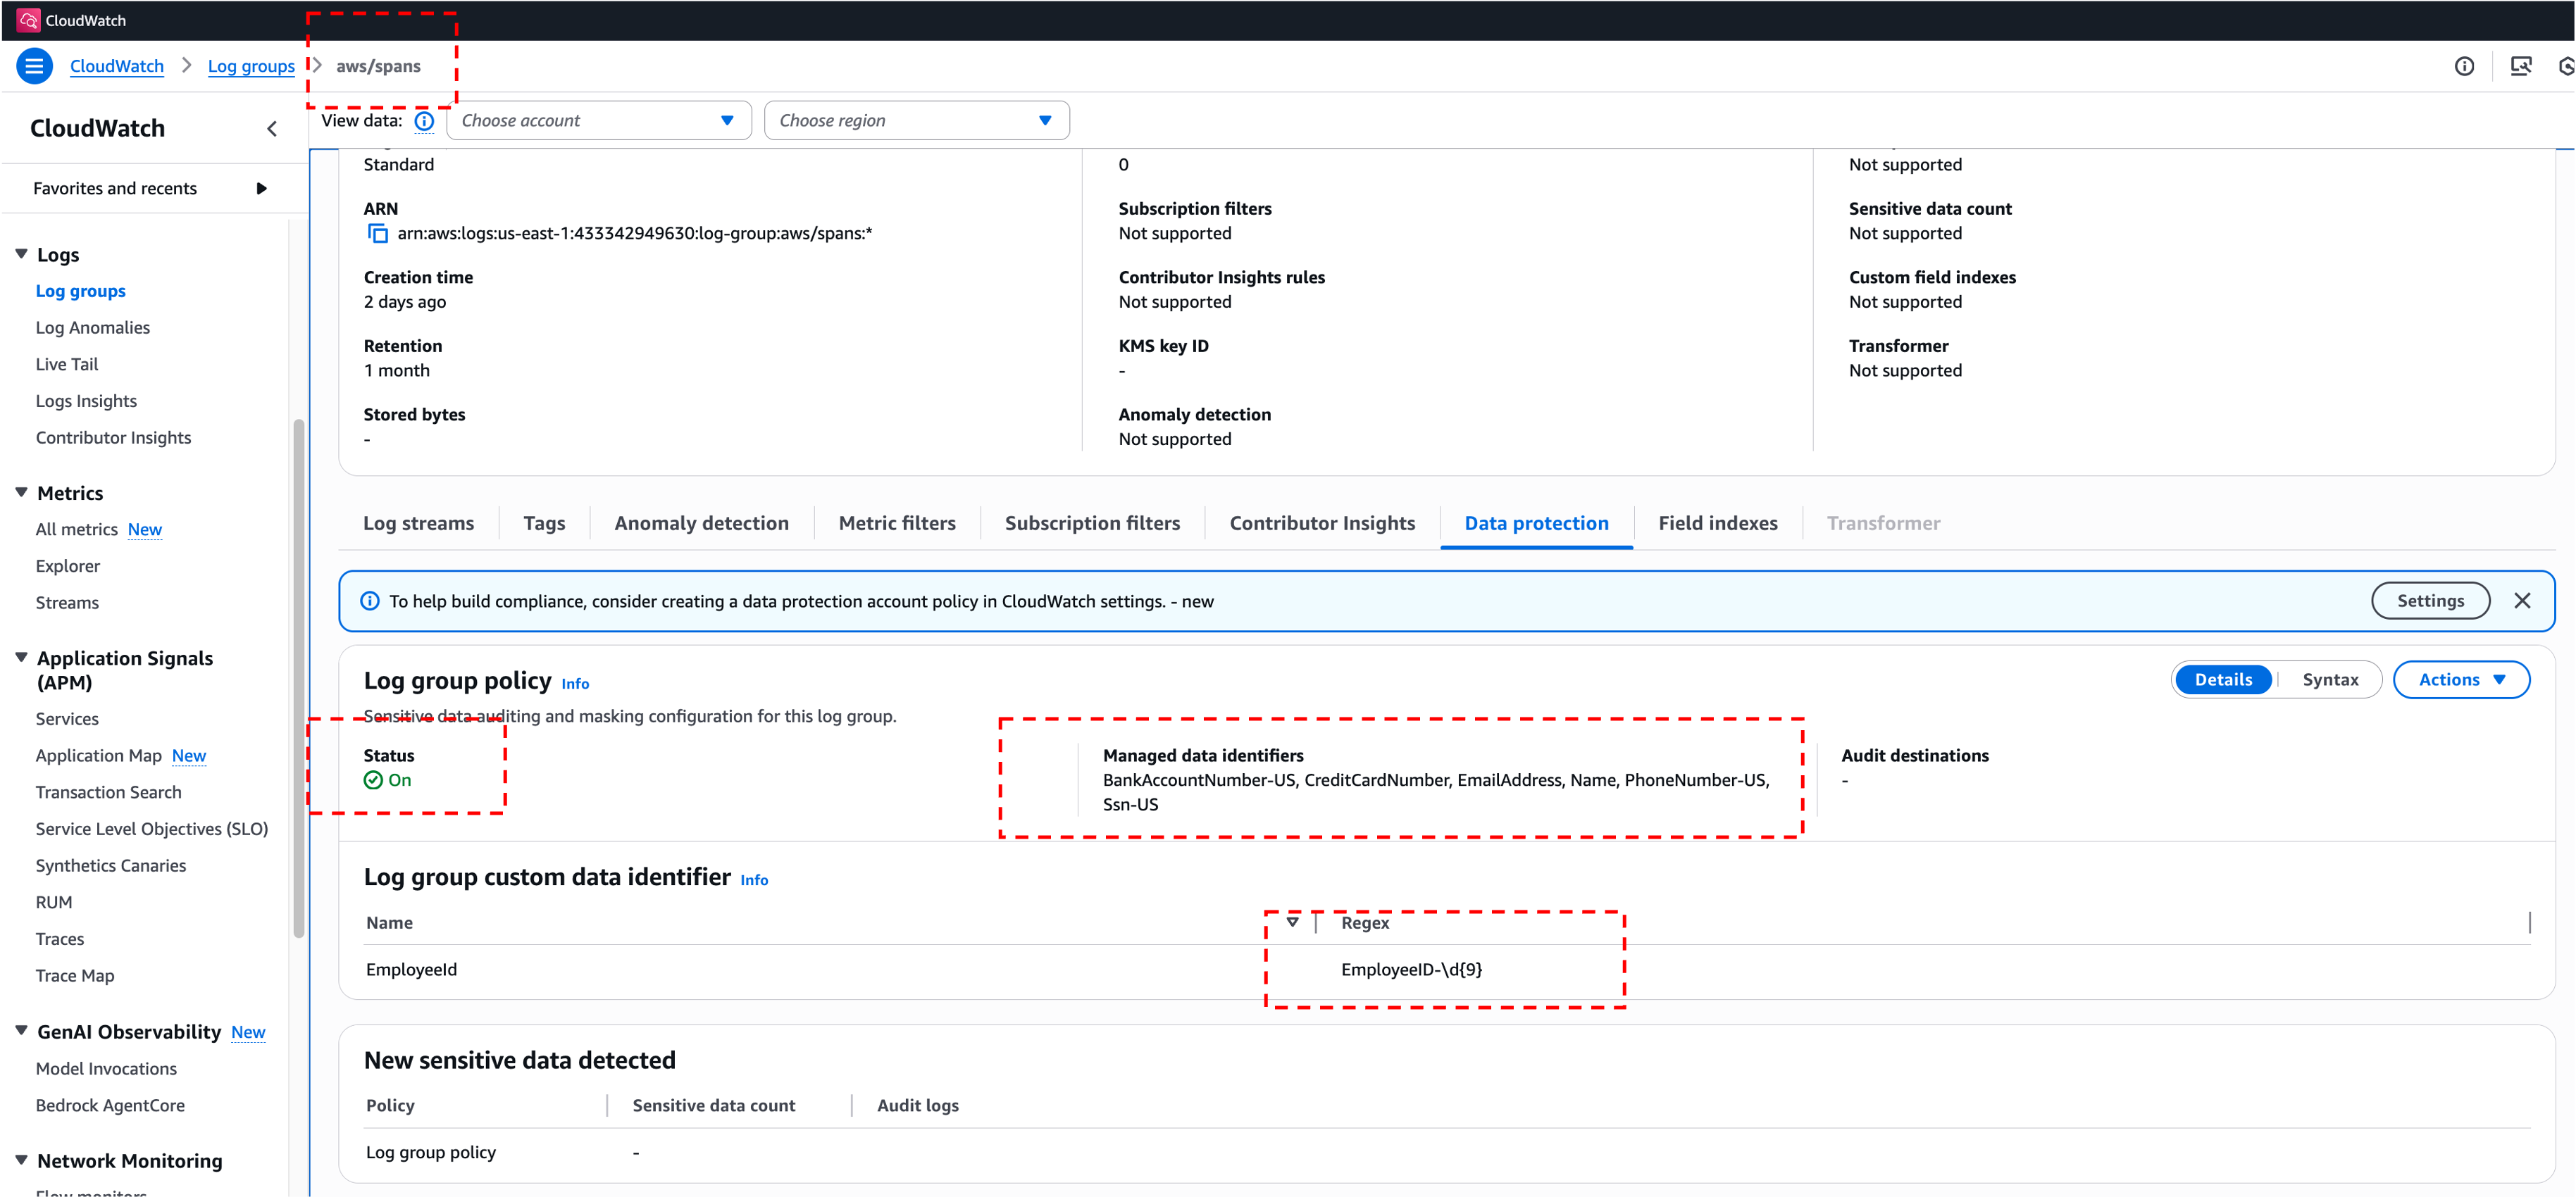



Lets create the agent again and notice the sensitive information that we injected into the custom spans as below:

            main_span.set_attribute("agent.email", "jrussell@domain.com ")
            main_span.set_attribute("agent.phone", "301-555-0100")
            main_span.set_attribute("agent.id", "EmployeeID-123456789")

            


In [ ]:
%%writefile custom_span_agent.py
import os
import logging
import sys
import argparse
from opentelemetry import baggage, context
from opentelemetry import trace

def parse_arguments():
    parser = argparse.ArgumentParser(description='Agent with Custom Span Creation')
    parser.add_argument('--session-id', 
                       type=str, 
                       required=True,
                       help='Session ID to associate with this agent run')
    return parser.parse_args()

def set_session_context(session_id):
    """Set the session ID in OpenTelemetry baggage for trace correlation"""
    ctx = baggage.set_baggage("session.id", session_id)
    token = context.attach(ctx)
    logging.info(f"Session ID '{session_id}' attached to telemetry context")
    return token

###########################
#### Agent Code below: ####
###########################

from strands import Agent, tool
from strands.models import BedrockModel
from ddgs import DDGS

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configure Strands logging
logging.getLogger("strands").setLevel(logging.INFO)

@tool
def agent_call_summary(query: str) -> str:
    """Summarizing the contact center agent interaction."""
    # Get the tracer - use the service name for better trace organization
    tracer = trace.get_tracer("agent_call_summary", "1.0.0")
    
    # Start a new span for the web search operation
    with tracer.start_as_current_span("custom agent call summary tool") as span:
        try:
            # Add query attribute
            span.set_attribute("search.query", query)
            span.set_attribute("tool.name", "agent_call_summary")
            span.set_attribute("search.provider", "call logs")
            
            # Add event for search start
            span.add_event("search_started", {"query": query})
            
            
            results = open('./data/customer_support_conversation_sample.txt', 'r').read()
            
            # Add results count attribute
            span.set_attribute("search.results_count", len(results))
                      
            span.set_attribute("search.results_summary", results[:500])  # Truncate for telemetry
            
            # Add success event
            span.add_event("search_completed", {
                "results_count": len(results),
                "success": True
            })
            
            # Set span status to OK
            span.set_status(trace.Status(trace.StatusCode.OK))
            
            logger.info(f"agent conversation search completed successfully for query: {query[:50]}...")
            return results
            
        except Exception as e:
            # Add error information
            span.set_attribute("search.error", str(e))
            span.set_attribute("search.error_type", type(e).__name__)
            
            # Add error event
            span.add_event("search_failed", {
                "error": str(e),
                "error_type": type(e).__name__
            })
            
            # Set span status to ERROR
            span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            
            logger.error(f"Web search failed: {str(e)}")
            return f"Search error: {str(e)}"

def get_bedrock_model():
    model_id = os.getenv("BEDROCK_MODEL_ID", "anthropic.claude-3-haiku-20240307-v1:0")
    region = os.getenv("AWS_DEFAULT_REGION", "us-east-1")    
    
    try:
        bedrock_model = BedrockModel(
            model_id=model_id,
            region_name=region,
            temperature=0.7,
            max_tokens=512,
            guardrail_id="c1zmotfiqwin",      # Your Bedrock guardrail ID
            guardrail_version="1",            # Guardrail version
            guardrail_trace="enabled",        # Enable trace info for debugging            
        )
        logger.info(f"Successfully initialized Bedrock model: {model_id} in region: {region}")
        return bedrock_model
    except Exception as e:
        logger.error(f"Failed to initialize Bedrock model: {str(e)}")
        logger.error("Please ensure you have proper AWS credentials configured and access to the Bedrock model")
        raise

def main():
    # Parse command line arguments
    args = parse_arguments()
    
    # Set session context for telemetry
    context_token = set_session_context(args.session_id)
    
    # Get tracer for main application
    tracer = trace.get_tracer("strands_customer_agent", "1.0.0")
    
    with tracer.start_as_current_span("customer_agent_session") as main_span:
        try:
            # Add session attributes to main span
            main_span.set_attribute("session.id", args.session_id)
            main_span.set_attribute("agent.type", "customer_agent")
            main_span.set_attribute("agent.email", "jrussell@domain.com ")
            main_span.set_attribute("agent.phone", "301-555-0100")
            main_span.set_attribute("agent.id", "EmployeeID-123456789")
            
            # Initialize Bedrock model
            bedrock_model = get_bedrock_model()

            # Create customer support agent
            support_agent = Agent(
                model=bedrock_model,
                system_prompt="""You are an expert customer support conversation agent specializing in finding 
                                 accurate and relevant information. Your role is to efficiently search, analyze, and synthesize
                                 information provided to answer user queries comprehensively. You should provide
                                 well-researched responses with current information, clear summaries, and cite reliable sources
                                 when presenting your findings. """,
                tools=[agent_call_summary],
                trace_attributes={
                    "user.id": "user@domain.com",
                    "tags": ["Strands", "Observability"],
                }
            )

            # Execute the customer research task
            query = """summarize the agent conversation. Tell me the phone number, name, address, and email?"""

            main_span.add_event("agent_query_started", {"query": query[:100]})
            
            result = support_agent(query)
            
            main_span.add_event("agent_query_completed", {"success": True})
            main_span.set_status(trace.Status(trace.StatusCode.OK))
            
            print("Result:", result)
            
        except Exception as e:
            main_span.set_attribute("error", str(e))
            main_span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            logger.error(f"Main execution failed: {str(e)}")
            raise
        finally:
            # Detach context when done
            context.detach(context_token)
            logger.info(f"Session context for '{args.session_id}' detached")

if __name__ == "__main__":
    main()



Run the agent as below:



In [ ]:
!opentelemetry-instrument python custom_span_agent.py --session-id "custom-span-demo-26"


Review the results with both guardrails and logs data protection enabled.

Agent interaction below (your exact output may vary, but concept still applies):


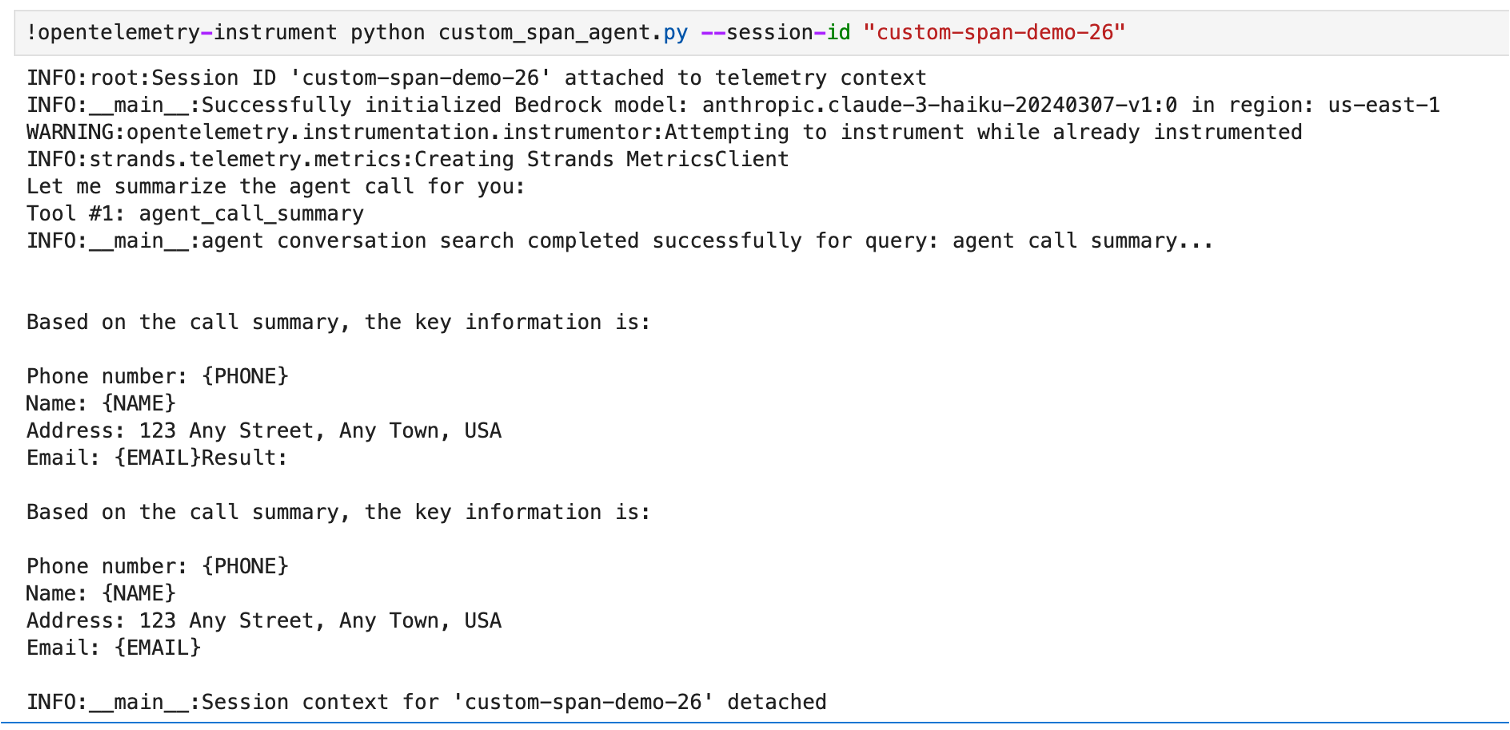


We can now see that the sensitive information in the Custom Spans is also protected. Also notice the 'agent.id' is masked, which is based on the Custom Data Identifer with Regex.


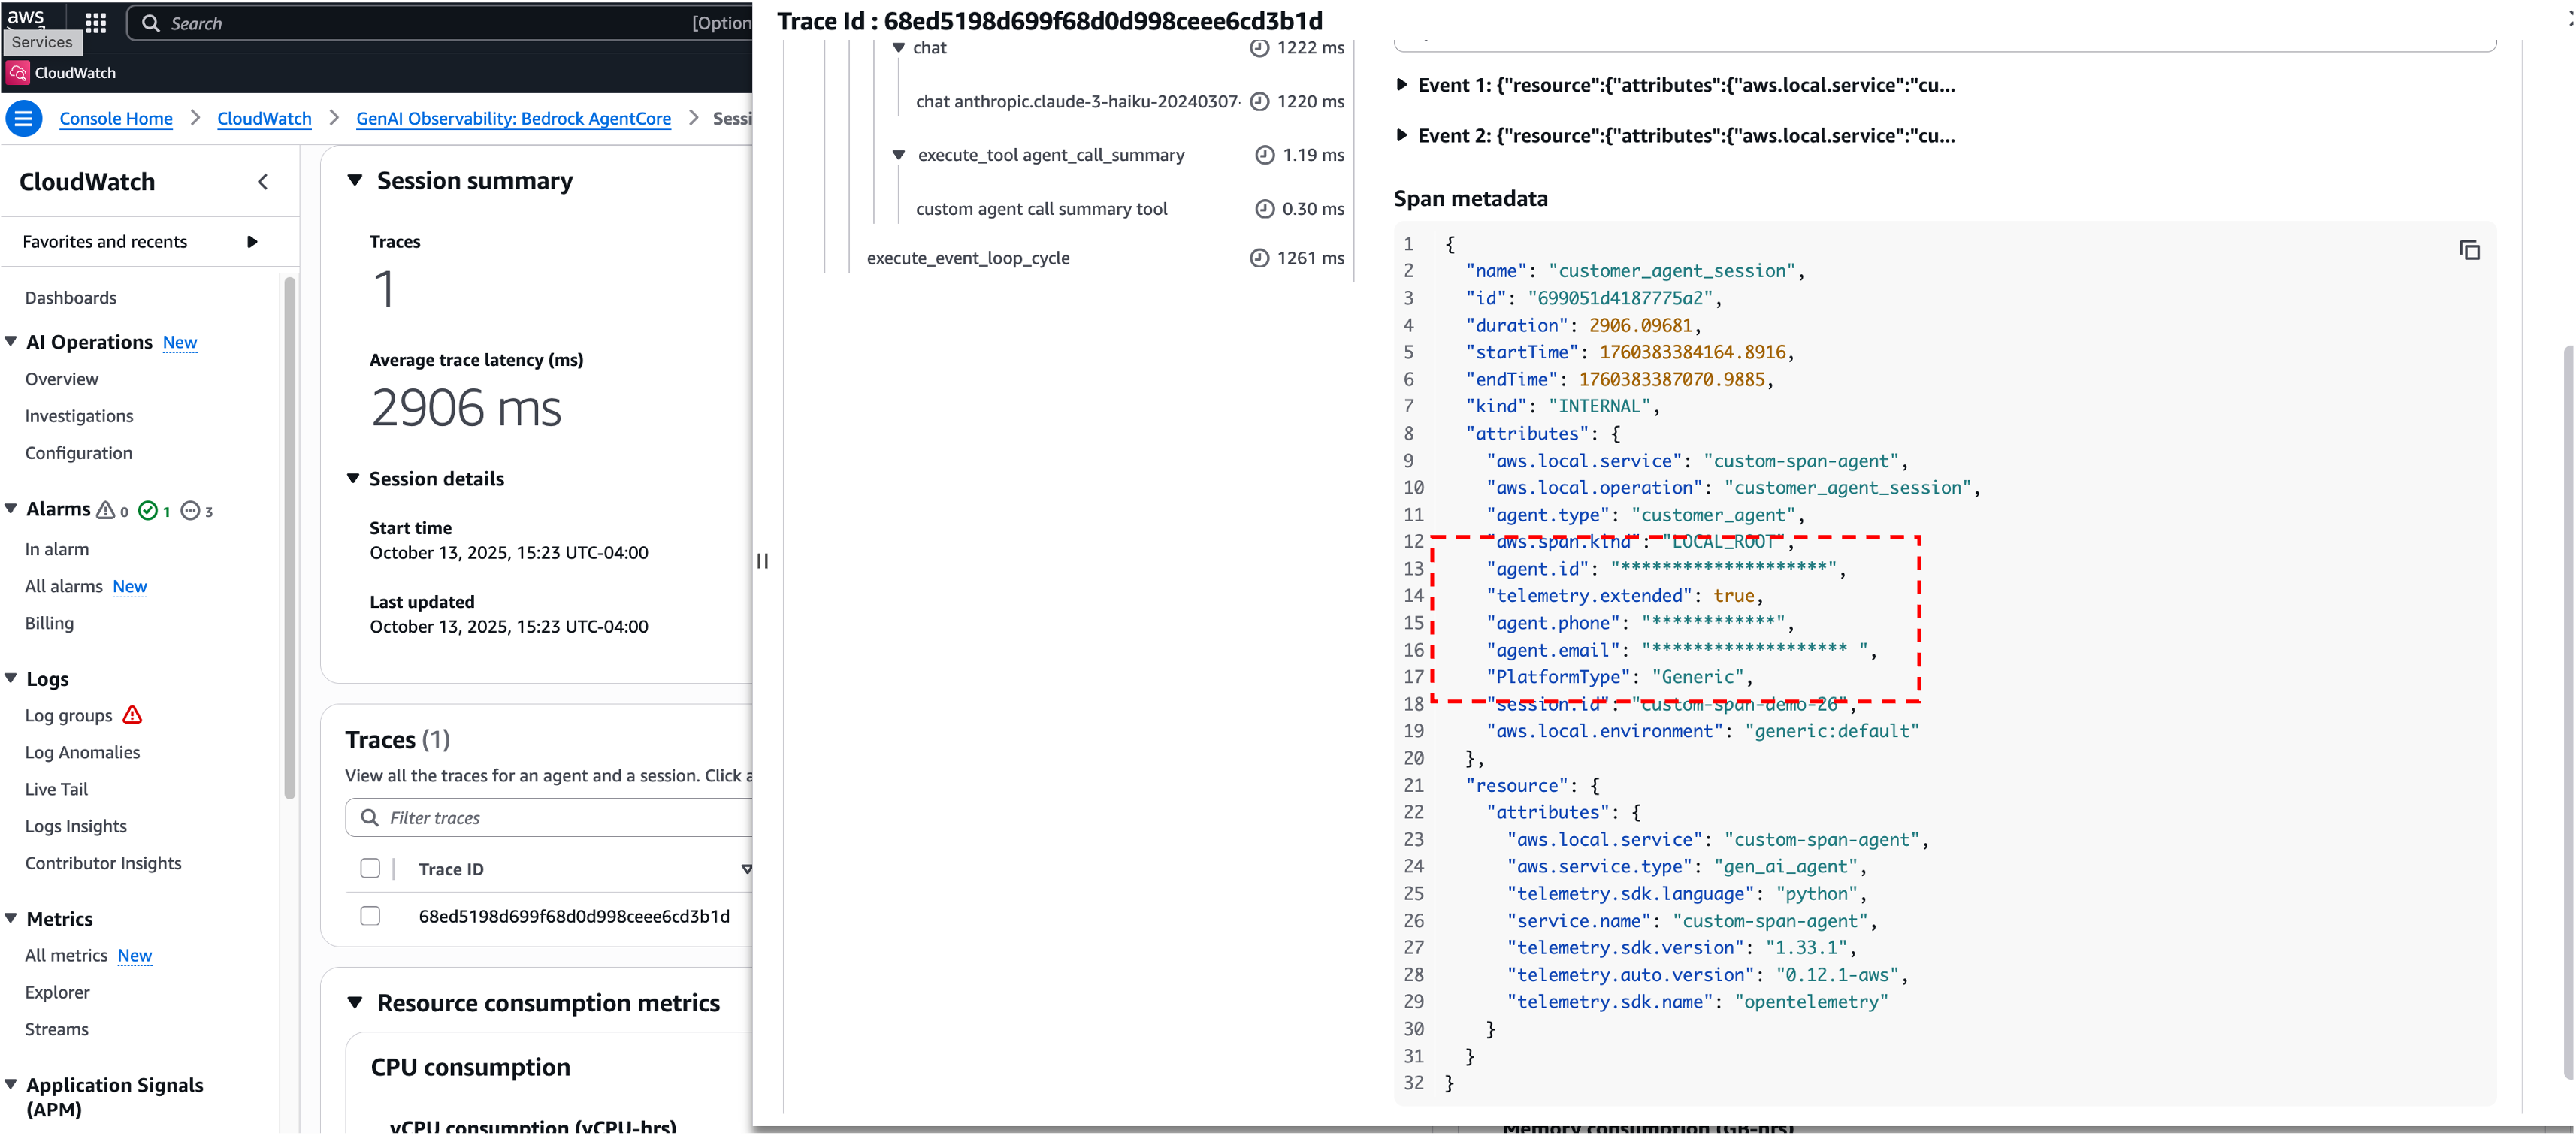



# 5. Conclusion

**Key Takeaways**
Congratulations! You've successfully learned how to implement comprehensive data protection measures for your agents. Let's recap what we've covered:

What We Accomplished

✅ Configured Bedrock Guardrails to:

- Redact sensitive information
- apply guardrails to your agents

✅ Enabled CloudWatch Logs Data Protection to:

- Automatically detect and mask sensitive data in logs
- Implement data identifiers for sensitive data, and custom patterns

✅ Integrated both features seamlessly with Bedrock Agent Core for production-ready deployments


**Best Practices**

- Layer your defenses: Use both guardrails (runtime protection) and logs data protection (post-processing security)
- Test thoroughly: Validate your guardrail policies with diverse test cases before production deployment
- Monitor and iterate: Regularly review CloudWatch metrics and audit logs to refine your configurations
- Principle of least privilege: Ensure IAM roles have only the permissions necessary for guardrails and logging
- Document your policies: Maintain clear documentation of what content is filtered and why


**Next Steps**
To further enhance your AI agent security:

- Explore custom word filters and regex patterns for industry-specific terminology
- Implement A/B testing with different guardrail configurations
- Set up CloudWatch alarms for guardrail intervention metrics
- Consider AWS KMS encryption for your log groups containing sensitive operations


**Additional Resources**

- [CloudWatch Logs data protection audit findings](https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/mask-sensitive-log-data-audit-findings.html)
- [Account-wide policy](https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/mask-sensitive-log-data-accountlevel.html)
- [Bedrock Guardrails use cases](https://docs.aws.amazon.com/bedrock/latest/userguide/guardrails-use.html)


**Remember**: Responsible AI is not a one-time configuration — it's an ongoing commitment. Continue to monitor, evaluate, and improve your safeguards as your agents evolve and new threats emerge.

Happy building, and stay secure! 🛡️🤖

